In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras import models
from keras import layers
from keras import optimizers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.utils.np_utils import to_categorical  # convert to one-hot-encoding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

%matplotlib inline

Using TensorFlow backend.


## Load model

In [2]:
model = load_model('InterceptionV3_orignial.h5')
print("Loaded model")
(img_rows, img_cols, nb_channels) = (299,299, 3)
image_shape = (img_rows, img_cols, nb_channels)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Loaded model


## Load train_val data

In [3]:
data = pd.read_csv('../data/train.csv')
X_data = data['ImageId']
y_data = data['Malignant']
X_id = X_data.values
Y = y_data.values
    
X = np.zeros((data['ImageId'].shape[0],img_rows, img_cols, nb_channels))
for i in range(X_id.shape[0]):
    name = X_id[i]
    filename = '../data/im/{}.jpg'.format(name)
    image = imread(filename)
#     filename_Segmentation = 'data/im/{}_segmentation.jpg'.format(name)
#     image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
#     image_Segmentation_boolean = (image_Segmentation/255).astype(np.uint8) # To get uint8
#     image_Segmentation_expand = np.expand_dims(image_Segmentation_boolean, axis=2)
#     image_mul_mask = (image_Segmentation_expand*image) 
    image = resize(image,image_shape, mode='reflect')
    #image_mul_mask = resize(image_mul_mask,image_shape, mode='reflect')
    X[i]= image#_mul_mask
print("Loaded file")

/Users/lin/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Loaded file


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

105/105 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        61
           1       0.00      0.00      0.00        44

   micro avg       0.58      0.58      0.58       105
   macro avg       0.29      0.50      0.37       105
weighted avg       0.34      0.58      0.43       105

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


/Users/lin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


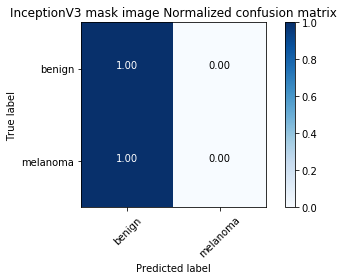

In [6]:
y_pred = model.predict(X_val,verbose=1)

threshold = 0.5#np.median(y_val)
y_pred[y_pred>threshold]=1
y_pred[y_pred<=threshold]=0
class_names = ["benign","melanoma"]
print(classification_report(y_val, y_pred))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='InceptionV3 mask image Normalized confusion matrix')
plt.show()

## Load test data

In [ ]:
df_submission = pd.read_csv('../data/test.csv')
X_data= df_submission['ImageId']
X_id = X_data.values
    
X_test = np.zeros((df_submission['ImageId'].shape[0],img_rows, img_cols, nb_channels))
for i in range(X_id.shape[0]):
    name = X_id[i]
    filename = 'data/im/{}.jpg'.format(name)
    image = imread(filename)
#     filename_Segmentation = 'data/im/{}_segmentation.jpg'.format(name)
#     image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
#     image_Segmentation_boolean = (image_Segmentation/255).astype(np.uint8) # To get uint8
#     image_Segmentation_expand = np.expand_dims(image_Segmentation_boolean, axis=2)
#     image_mul_mask = (image_Segmentation_expand*image) 
    image = resize(image,image_shape, mode='reflect')
#     image_mul_mask = resize(image_mul_mask,image_shape, mode='reflect')
    X_test[i]= image#_mul_mask
print("Loaded file")

In [ ]:
y_test = model.predict(X_test,verbose=1)
print(y_test)

In [ ]:
print(np.median(y_test))
print(y_test.mean())
print(y_test.max())
print(y_test.min())
print(y_test.std())

In [ ]:
#write to file
#df_submission.loc[:, 'Malignant'] = np.argmax(y_test,axis=1)
threshold = 0.5 #np.median(y_test)
y_test[y_test>threshold]=1
y_test[y_test<=threshold]=0
df_submission.loc[:, 'Malignant'] = y_test #np.argmax(y_test,axis=1)
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('../data/test_InterceptionV3_original.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file